Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
%matplotlib inline

# Part 1: The seven scientists

This example is due to [MacKay 2003, exercise 22.15] and [Lee & Wagenmaker 2013, section 4.2].

Suppose seven scientists all go and perform the same experiment, each collecting a measurement $x_i$ for $i = 1,\dots,7$, of an underlying physical value $\mu$. 
 
These scientists are varyingly good at their job, and while we can assume each scientist would estimate $\mu$ correctly _on average_, some of them may have much more error in their measurements than others.

They come back with the following seven observations:


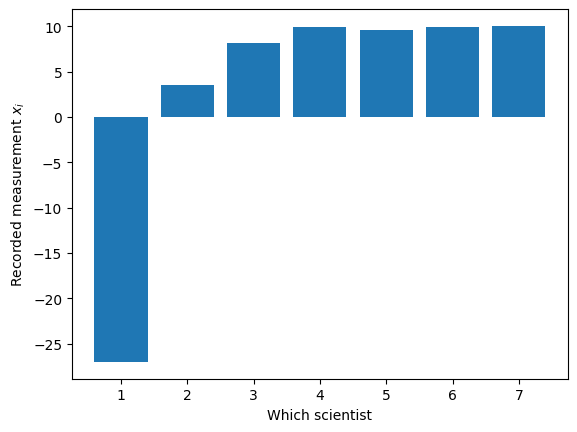

In [2]:
measurements = torch.FloatTensor([-27.020, 3.570, 8.191, 9.898, 9.603, 9.945, 10.056])

plt.bar(np.arange(1,8), measurements) # , "o")
plt.xlabel("Which scientist")
plt.ylabel("Recorded measurement $x_i$");

From looking at the plot, clearly one scientist does not know what they are doing (and some of the others are probably a little suspect too)!


### A model for the data

In this exercise we will suppose that there is "scientist-specific" standard deviation $\sigma_i$, which describes how accurately each of them might perform the experiment:

$$\begin{align}
x_i &\sim \mathrm{Normal}(\mu, \sigma_i^2).
\end{align}$$

Scientists with low $\sigma_i$ produce good estimates of $x$, whereas scientists with high $\sigma_i$ might have wildly inaccurate estimates. However, we don't know _which_ scientists are good -- and we only have one observation from each!

We can ask two questions:

* What is the "real" value of $\mu$?
* What are the values of $\sigma_i$ for each scientists?



### Bayesian inference approach

You will have to choose priors for the mean $\mu$ of the measurements, and for the error standard deviation $\sigma\_i$ for each of the $i$ scientists. A good starting point is

$$\begin{align}
\mu &\sim \mathrm{Normal}(0, \alpha^2) \\
\sigma_i &\sim \mathrm{Exponential}(\beta)
\end{align}$$

where $\alpha=50$ and $\beta=0.5$. This is a prior distribution with mean 2 that places diminishing probability density on larger values of $\sigma_i$:


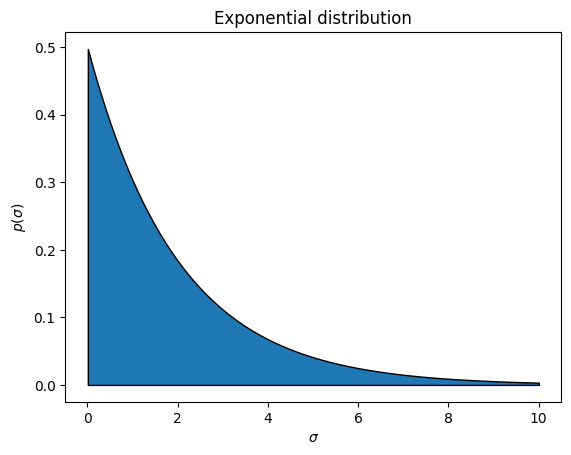

In [3]:
plt.fill_between(np.linspace(0.01,10,100), 0.0, 
                 dist.Exponential(rate=0.5).log_prob(torch.linspace(0.01,10,100)).exp(), 
                 edgecolor='k');
plt.xlabel("$\sigma$")
plt.ylabel("$p(\sigma)$")
plt.title("Exponential distribution");

# TASK #1 (3 points): Define the model

Given $\alpha=50, \beta=0.5$, and the measurements $x$ above, write a function to compute the unnormalized log density

$$\log p(\mu, x_1,\dots,x_7, \sigma_1,\dots, \sigma_7 | \alpha, \beta)$$

In [4]:
def log_joint(mu, sigma, alpha=50, beta=0.5):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    log_joint: the log probability log p(mu, sigma, x | alpha, beta), scalar
    
    NOTE: For inputs where sigma <= 0, please return negative infinity!

    """
    assert mu.ndim == 0
    assert sigma.shape == (7,)

    if torch.any(sigma <= 0):
        return -np.inf
    
    # mu_prior, p(mu)
    log_mu_prior = dist.Normal(loc = 0, scale = alpha, validate_args=False).log_prob(mu).sum(0)

    # sigma_prior, p(sigma_1, ..., sigma_7) 
    log_sigma_prior = dist.Exponential(rate = beta).log_prob(sigma).sum(0)

    # Likelihood p(x1, …, x7 | mu, sigma_1, ..., sigma_7)
    log_likelihood = dist.Normal(loc = mu, scale = sigma, validate_args=False).log_prob(measurements).sum(0)

    return log_mu_prior + log_sigma_prior + log_likelihood


#### Ignore the following cells. 

They consist of "hidden" test cases, and are used by the grading system.

In [5]:
# (GRADING)

In [6]:
# (GRADING)

# TASK #2 (5 points): Implement an MCMC sampler

Your second task is to implement an MCMC algorithm to sample from the posterior distribution

$$p(\mu, \sigma | x, \alpha, \beta).$$

To do this, you need to implement two functions:

* `get_mcmc_proposal`: this takes in current values of $\mu$ and $\sigma$, and returns pytorch `Distribution` objects (i.e., `torch.distributions.Distribution`, here in-scope as `dist.Distribution`) that will propose a next value given the current value, $q(\mu' | \mu, \dots)$ and $q(\sigma' | \sigma, \dots)$. It is **your choice** what sort of distribution to use here! Just make sure that whatever you propose works well in your MCMC algorithm.

* `mcmc_step`: this takes in current values of $\mu$ and $\sigma$, and runs a single Metropolis-Hastings step:
  1. sample candidate values from the proposal distribution you defined
  2. compute an acceptance probability, and either accept or reject
  3. return $\mu, \sigma$

In [7]:
def get_mcmc_proposal(mu, sigma):
    """
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0

    OUTPUT:
    q_mu    : instance of Distribution class, that defines a proposal for mu
    q_sigma : instance of Distribution class, that defines a proposal for sigma
    """

    assert mu.ndim == 0, f"scalar mu expected, got: {mu}"
    assert sigma.shape == (7,), f"sigma expected vector of length 7, got: {sigma} "
    assert torch.all(sigma > 0), f"sigma > 0 expected, got: {sigma}"

    # q_mu, Normal(mu_i, 1)
    mu_proposal_std = 0.225
    q_mu = dist.Normal(loc = mu, scale = mu_proposal_std, validate_args=False)

    # q_sigma, Normal(mu_i, 1)
    sigma_proposal_std = torch.tensor([1, 0.7, 0.6, 0.2, 0.2, 0.2, 0.3])
    q_sigma = dist.Normal(loc = sigma, scale=sigma_proposal_std)

    return q_mu, q_sigma
    

### Quick self-check!

If your `get_mcmc_proposal` has the correct function signature, all the following assertions should be true:

In [8]:
q_mu, q_sigma = get_mcmc_proposal(torch.tensor(9.0), torch.ones(7))
assert isinstance(q_mu, dist.Distribution)
assert isinstance(q_sigma, dist.Distribution)
assert q_mu.sample().shape == ()
assert q_sigma.sample().shape == (7,)
del q_mu, q_sigma

In [9]:
def mcmc_step(mu, sigma, alpha=50, beta=0.5):
    """
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian prior on mu. Default to 50
    beta  : scalar, rate of exponential prior on sigma_i. Default to 0.5

    OUTPUT:
    mu       : the next value of mu in the MCMC chain
    sigma    : the next value of sigma in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted

    """

    assert mu.ndim == 0, f"scalar mu expected, got: {mu}"
    assert sigma.shape == (7,), f"sigma expected vector of length 7, got: {sigma} "
    assert torch.all(sigma > 0), f"sigma > 0 expected, got: {sigma}"
    
    accepted = False

    # get proposal distributions
    q_mu, q_sigma = get_mcmc_proposal(mu, sigma)

    # get candidates
    candidate_mu = q_mu.sample()
    candidate_sigma = q_sigma.sample()

    # get u ~ Unif([0, 1])
    u = torch.rand(1).log().item()

    # pie(candidate) & pie(current)
    try:
        candidate_posterior_density = log_joint(mu=candidate_mu, sigma=candidate_sigma, alpha=alpha, beta=beta)
    except ValueError:
        candidate_posterior_density = -torch.inf
    
    current_posterior_density = log_joint(mu=mu, sigma=sigma, alpha=alpha, beta=beta)

    # log Hasting's Ratio
    log_H = candidate_posterior_density - current_posterior_density

    if u < log_H:
        accepted = True
        return candidate_mu, candidate_sigma, accepted
    else:
        return mu, sigma, accepted

## Running MCMC

We've supplied the outer loop for you -- it will call and execute your `mcmc_step` function. You should *not* need to edit it!

You do need to fill in the function `algo_parameters`, though, which just returns the total number of iterations you decide to run the MCMC chain, and the number of samples to discard as "burnin".

In [10]:
def run_mcmc(N_iters, mu_init, sigma_init):
    """ Run an MCMC algorithm for a fixed number of iterations """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    N_accepted = 0
    for _ in range(N_iters):
        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
        N_accepted += accepted
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), N_accepted / N_iters

In [11]:
def algo_parameters():
    """ 
    OUTPUT:
    N_samples : total number of MCMC steps
    N_burnin  : number of initial steps to discard
    """

    N_samples = 50000
    N_burnin = int(0.2*N_samples)
    
    return N_samples, N_burnin

## Initialize, run, and display diagnostics

The following code initializes the MCMC sampler, executes it for the number of iterations you specified, and then plots a handful of diagnostics.

Use these diagnostics to decide whether or not you have done this properly! Take some time to try to interpret the results, and feel free to play around with the plots a bit.

In [12]:
mu_init = measurements.mean()
sigma_init = torch.ones(7)

N_samples, N_burnin = algo_parameters()

mu_chain, sigma_chain, accepted = run_mcmc(N_samples, mu_init, sigma_init)
print("acceptance rate:", accepted)

acceptance rate: 0.21228


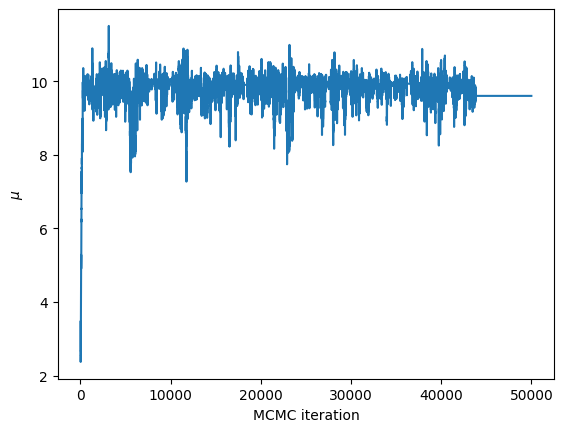

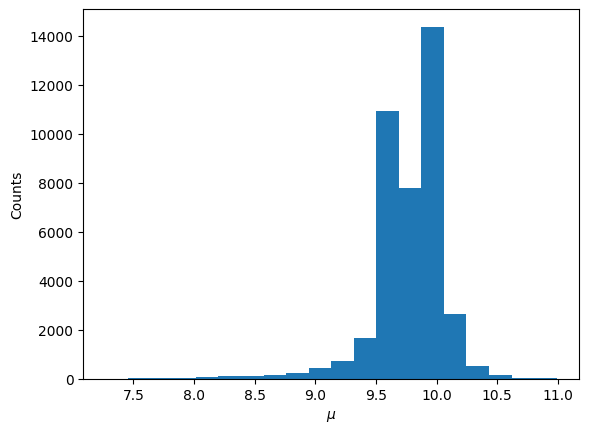

In [13]:
plt.plot(mu_chain);
plt.xlabel("MCMC iteration");
plt.ylabel("$\mu$")
plt.figure();
plt.hist(mu_chain[N_burnin:].numpy(), bins=20);
plt.xlabel("$\mu$")
plt.ylabel("Counts");

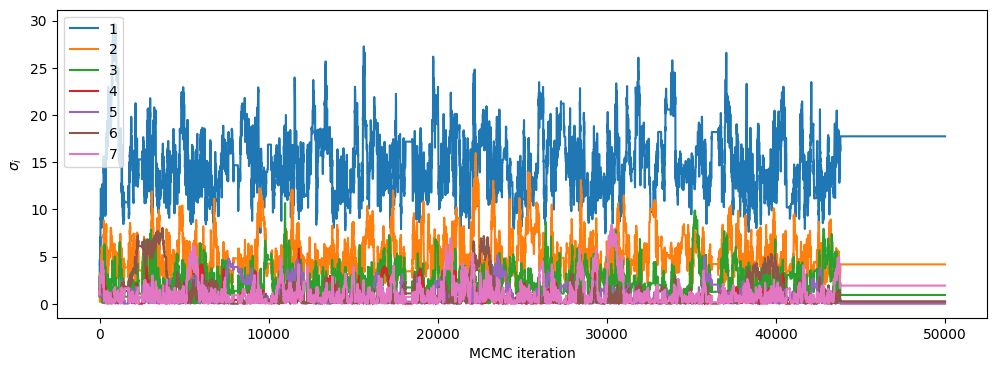

In [14]:
plt.figure(figsize=(12,4));
plt.plot(sigma_chain)
plt.legend(range(1,8));
plt.xlabel("MCMC iteration")
plt.ylabel("$\sigma_i$");

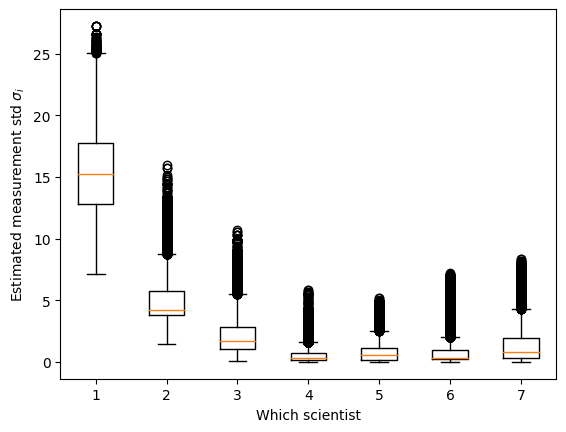

In [15]:
plt.boxplot(sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

# TASK #3 (2 points): Estimate posterior expectations

We're specifically interested in using the samples to answer the following:

1. What is the expected value of $\mu$, i.e., $\mathbb{E}[\mu ]$, under the posterior distribution?
2. What is the posterior probability that $\mu$ is less than 9, i.e. $\Pr(\mu < 9.0)$?

Both of these questions can be answered by using samples from your MCMC chain.

In [16]:
def estimate_E_mu(mu_chain, sigma_chain, N_burnin):
    """ Estimate E[mu] 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    mu : expected value of mu (scalar)
    """
    
    burnt_mu_chain = mu_chain[N_burnin:]

    mu = torch.mean(burnt_mu_chain)

    return mu
    
def estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin):
    """ Estimate the posterior probability that mu is less than 9, i.e. Pr(mu < 9) 
    
    INPUTS:
    mu_chain    : sequence of MCMC samples of mu
    sigma_chain : sequence of MCMC samples of sigma 
    N_burnin    : number of initial MCMC samples to discard as burnin 
    
    OUTPUTS:
    estimate : estimate of Pr(mu < 9), a scalar
    """

    burnt_mu_chain = mu_chain[N_burnin:]

    pr_mu_lt_9 = len(burnt_mu_chain[burnt_mu_chain < 9]) / len(burnt_mu_chain)

    return pr_mu_lt_9

In [17]:
print("E[mu] = %0.4f" % estimate_E_mu(mu_chain, sigma_chain, N_burnin))
print("Pr(mu < 9) = %0.4f" % estimate_pr_mu_lt_9(mu_chain, sigma_chain, N_burnin))

E[mu] = 9.7764
Pr(mu < 9) = 0.0198


# SHORT ANSWER SECTION (4 points)

Please answer the following 2 questions, for up to two points each:

1. Describe your choices of MCMC proposal distributions. How did you select them? How do you know they are "good"?
2. In your `mcmc_step`, we consider 8 random variables, $\mu, \sigma_1, \dots, \sigma_7$, but you probably implemented this using a single accept-reject step (i.e., you propose new values for all random variables, and then jointly accept all of them, or not). Suppose someone suggested instead proposing for each of these variables one-at-a-time sequentially, including a separate accept-reject step after each. Might this be a good idea, and why or why not?

**QUESTION 1**

For an arbitrary posterior distribution (or more generally any target distribution), a good proposal distribution assigns a non-zero probability of moving to states with non-zero probability in the posterior/target. That is to say, the support of the posterior/target is a subset of the support of the proposal. Therefore, the choice of a Gaussian proposal for both $\mu$ and $\sigma_{1:7}$ satisfies this condition by being defined on the entire real line. As a result, with the correct parameterisation, the choice of a Gaussian proposal guarantees that we can explore the entire space of the posterior/target.

i.e 

$$ \text{Support}\left(p(\mu, \sigma_1, ..., \sigma_7)\right) \subseteq \text{Support}\left(q(\mu, \sigma_1, ..., \sigma_7)\right) $$

In addition, another important requirement for the proposal distribution is that they spread their probability mass in the *correct* way. That is, to not wastefully sample a large number of samples with a high probability of rejection, the samples from the proposal are appropriate and hence provide a high chance of exploring the entirety of the posterior/target. Further, since we expect the posterior for both the scientist-specific variance $\sigma_{i}$ and true underlying physical value $\mu$ to be uni-modal waiving the worry of our MCMC chain getting stuck under one mode of the poster/target. Therefore, a Gaussian proposal is again a sensible choice. 

Finally, another advantage of selecting Gaussian proposals is that they are symmetric. That is, $q(x^{'}|x) = q(x|x^{'})$ and as a result, the Hasting correction reduces to $1$ simplifying the MCMC algorithm to the random walk Metropolis Algorithm that is more intuitive (move to states with higher posterior density), and hence the acceptance probility is given by:

$$ r = min(1, \frac{p^*(x^{'})}{p^*(x)}) $$


Now that the distribution family for the proposals is justified, attention can be directed to the choice of hyperparametrisisation of the proposals. That is, choosing the variance of the proposals for the true underlying physical value $\mu$ and the scientist-specific variances $\sigma_i$. After running a couple of pilot runs to tune the variance choices we can see from the diagnostic plots that we get MCMC chains that are exploring the state space well and not getting stuck on a plateau or exploring too slowly. That is, it is exploring the support of the posterior in a manner which is proportional to its density. As a result, we expect that our samples are indeed from the posterior. Finally, according to the literature on MCMC, (Probabilistic Machine Learning - Kevin Murphy), an optimal acceptance rate for Gaussian target distributions is between 25% and 40% whereas our MCMC chain has an acceptance rate of approximately 25% after 50000 iterations providing a final sanity check.

Note: 
* Proposal Variance for $\mu$: $0.225$
* Proposal variances for $\sigma_{1:7}$: $[1, 0.7, 0.6, 0.2, 0.2, 0.2, 0.3]$


**QUESTION 2**

An advantage of component-wise sampling is when the number of dimensions of the sampling space becomes very large. That is, if our posterior/target distribution is over $d$ variables ($p(x_1, ..., x_d)$) where $d$ is large, then the proposal distribution also has to be over $d$ variables. We then propose a state $x^{'} \in \mathbb{R}^{d}$ that is either accepted or rejected. A problem that can be faced with this approach is that it can be difficult to find a suitable proposal, which leads to a large number of rejections. Therefore, the proposed remedy of looping through the $d$ dimensions in sequence and sampling independently could be a valid solution.

That said since we are assuming that the scientist-specific variances are independent of each other, and independent from the true underlying value $\mu$ our proposal factorises $q(\mu, \sigma_1, ..., \sigma_7) = q(\mu)q(\sigma_1)...q(\sigma_7)$. Therefore, finding a suitable proposal over all variables reduces to finding suitable proposals for each variable. As a result, the main benefit of component-wise sampling is reduced, at the expense of having the run 8 times more iterations to recover the same N_sample for each variable. This is because all other variables are kept fixed for each accept/reject step. So exploring the entire state space to the same extent as in Block-wise sampling requires N_variables * N_samples. Therefore, component-wise sampling may not be a good idea in this circumstance as clearly, it is much more inefficient.

#### Ignore the following cells. They are used by the grading system.

In [18]:
# (GRADING)

In [19]:
# (GRADING)

In [20]:
# (GRADING)

In [21]:
# (GRADING)

In [22]:
# (GRADING)

# EXTRA CREDIT TASK #4 (2 points): Estimate $\alpha$ and $\beta$

Did we choose the hyperparameters $\alpha$ and $\beta$ well? Or were these poor selections?

One way of checking whether $\alpha$ and $\beta$ are set well is by computing a marginal likelihood estimate, i.e. estimating $p(x | \alpha, \beta)$ for different choices of $\alpha, \beta$.

However, a different option is to *also* perform Bayesian inference over $\alpha$ and $\beta$! To do this, we need to do three things:

1. Define a prior $p(\alpha, \beta)$
2. Define MCMC proposals $q(\alpha' | \alpha)$ and $q(\beta' | \beta)$
3. Update the MCMC algorithm itself to also sample $\alpha, \beta$.

To do this, this involves targeting the joint probability distribution

$$p(x,\mu,\sigma,\alpha,\beta) = p(x | \mu, \sigma)p(\mu | \alpha)p(\sigma | \beta)p(\alpha)p(\beta).$$

You can write your MCMC algorithm so that it alternates between doing updates on $\mu, \sigma$ (using your existing `mcmc_step` function) and doing updates on $\alpha, \beta$ (using a new `mcmc_step_hyperparams` function).

To do this you need to implement two things:

1. `log_prior_alpha_beta`: given $\alpha,\beta$, return $\log p(\alpha, \beta)$. You are free to define whatever sort of prior you think is appropriate.
2. `mcmc_step_hyperparams`: do a single MCMC step (including accept / reject) to update $\alpha, \beta$.

These will then be called by the `run_mcmc_bonus` function, below.

In [23]:
def log_prior_alpha_beta(alpha, beta):
    """
    Define a prior distribution on alpha, beta, and return its log probability
    
    INPUT:
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    log_prob : scalar, `log p(alpha, beta)`
    
    """

    if beta < 0 or beta > 50:
        return -np.inf

    if alpha < 0 or alpha > 100:
        return -torch.inf
    
    # Gamma Prior centered around alpha = 50
    log_prior_alpha = dist.Uniform(low = 0, high = 100).log_prob(alpha)
    
    # Gamma Prior centered around beta = 0.5
    #log_prior_beta = dist.Gamma(concentration=2, rate = 4, validate_args=False).log_prob(beta)
    log_prior_beta = dist.Uniform(low = 0, high = 50).log_prob(beta)
    

    return log_prior_alpha + log_prior_beta


In [24]:
def mcmc_step_hyperparams(mu, sigma, alpha, beta):
    """
    Run an MCMC step on alpha and beta
    
    INPUT:
    mu    : scalar
    sigma : tensor, vector of length 7. Should have sigma > 0
    alpha : scalar, standard deviation of Gaussian distribution on mu
    beta  : scalar, rate of exponential distribution on sigma_i

    OUTPUT:
    alpha    : the next value of alpha in the MCMC chain
    beta     : the next value of beta in the MCMC chain
    accepted : a boolean value, indicating whether the proposal was accepted
    
    """
    accepted = False
    # Get Proposals
    ## Alpha ~ N(alpha, 7.5^2)
    alpha_proposal_std = 7.5
    q_alpha = dist.Normal(loc = alpha, scale = alpha_proposal_std, validate_args=False)

    ## Beta ~ N(beta, 0.3^2)
    beta_proposal_std = 0.3
    q_beta = dist.Normal(loc = beta, scale = beta_proposal_std, validate_args=False)

    # Get Candidates
    alpha_candidate = q_alpha.sample()
    beta_candidate = q_beta.sample()

    # get u ~ Unif([0, 1])
    u = torch.rand(1).log().item()

    # pie(candidate) & pie(current)
    try:
        candidate_posterior_density = log_joint(mu=mu, sigma=sigma, alpha=alpha_candidate, beta=beta_candidate) + log_prior_alpha_beta(alpha_candidate, beta_candidate)
    except ValueError:
        candidate_posterior_density = -torch.inf
    
    current_posterior_density = log_joint(mu=mu, sigma=sigma, alpha=alpha, beta=beta) + log_prior_alpha_beta(alpha, beta)

    # log Hasting's Ratio
    log_H = candidate_posterior_density - current_posterior_density

    # accept or reject proposal
    if u < log_H:
        accepted = True
        return alpha_candidate, beta_candidate, accepted
    else:
        return alpha, beta, accepted

### Run this MCMC algorithm, and plot the results.

What do you think?

1. Are these results qualitatively different?

**Answer:** Using un-informative (uniform) priors on $\alpha$ and $\beta$, the posterior for $\mu$ is qualitatively similar to the posterior we obtained without the inference on $\alpha$ and $\beta$ in the first part, with the exception of a heavier left-hand tail. the estimates of  $\sigma$ are also qualitatively similar. That is, they exhibit the same trend as we had in part 1 with fixed $\alpha$ and $\beta$ (on average decreasing scientist-specific variance from 1 to 7). That said, although the trend is preserved, we observe that the medians are also on average higher than in part 1. Therefore, we can conclude that our results are qualitatively similar. Or said another way, there are no glaring differences between the results with fixed $\alpha$ and $\beta$ compared to the case where we infer them.

2. Were the original choices of $\alpha, \beta$ reasonable?

**Answer:** From a visual check of the posterior, it seems that the evidence points towards having overestimated $\alpha$ and $\beta$ in the first part. Visually our MAP estimate might be $\alpha = 10$ and $\beta = 0.15$. (compare to $\alpha = 50$ and $\beta = 0.5$ that we used in part 1)

3. How sensitive are these results to $\alpha, \beta$? To $p(\alpha, \beta)$?

**Answer:** Given that we have multiple data points for $\mu$ and the underlying true value should not vary according to which scientist is taking the measurement, the prior and further, choice of $\alpha$ has less of an impact on the posterior. This is validated by our qualitative check on the posterior distribution of $\mu$ above. As a result, we conclude that our result for $\mu$ is less sensitive to $\alpha$. 

However, since we effectively only have a single point to estimate the scientist-specific variance given that these are scientist specific. These estimates are comparatively more sensitive to the choice of prior and hence $\beta$. This would explain why our medians and spread of data are slightly higher when we infer $\alpha$ and $\beta$. That said, the underlying trend and qualitative look of the results are not too different from part 1 where we fixed $\alpha$ and $\beta$. So we can conclude that although the $\sigma_i$ are more sensitive to the choice of $\beta$ they are not too sensitive broadly speaking.

In [25]:
def run_mcmc_bonus(N_iters, mu_init, sigma_init, alpha_init, beta_init):
    """ Run an MCMC algorithm for a fixed number of iterations.
    
    This also runs MCMC on "hyperparameters" alpha and beta.
    
    """
    
    mu_chain = [mu_init]
    sigma_chain = [sigma_init]
    alpha_chain = [alpha_init]
    beta_chain = [beta_init]
    for _ in range(N_iters):
        alpha, beta, accepted = mcmc_step_hyperparams(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        alpha_chain.append(alpha)
        beta_chain.append(beta)

        mu, sigma, accepted = mcmc_step(mu_chain[-1], sigma_chain[-1], alpha_chain[-1], beta_chain[-1])
        mu_chain.append(mu)
        sigma_chain.append(sigma)
    
    return torch.stack(mu_chain), torch.stack(sigma_chain), torch.stack(alpha_chain), torch.stack(beta_chain)

In [26]:
new_mu_chain, new_sigma_chain, alpha_chain, beta_chain = run_mcmc_bonus(N_samples, mu_chain[-1], sigma_chain[-1], torch.tensor(50.0), torch.tensor(0.5))

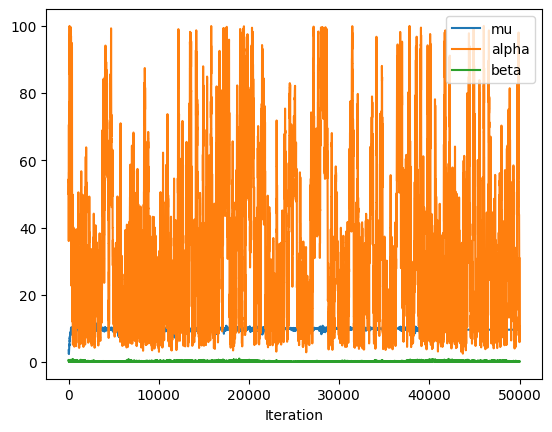

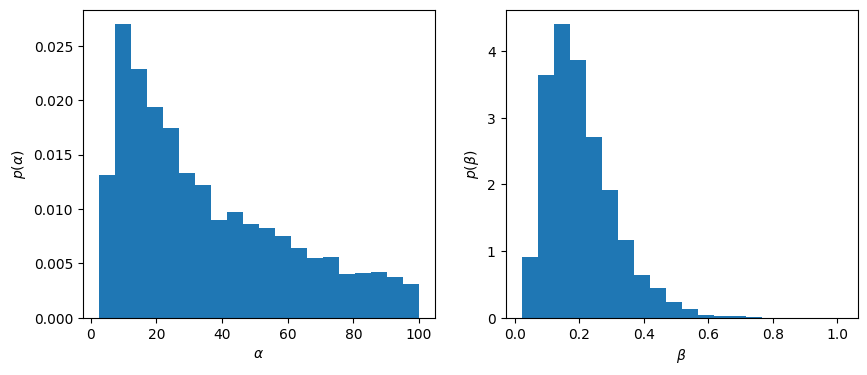

In [27]:
plt.plot(mu_chain)
plt.plot(alpha_chain);
plt.plot(beta_chain);
plt.legend(['mu', 'alpha', 'beta']);
plt.xlabel("Iteration");
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(alpha_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\alpha$")
plt.ylabel("$p(\\alpha)$")
plt.subplot(122)
plt.hist(beta_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\\beta$")
plt.ylabel("$p(\\beta)$");

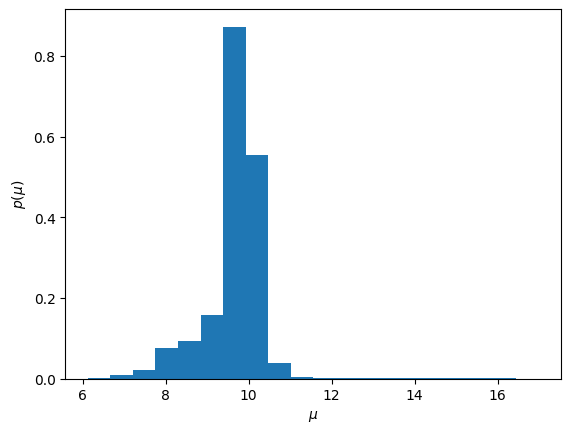

In [28]:
plt.hist(new_mu_chain[N_burnin:].numpy(), bins=20, density=True);
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$");

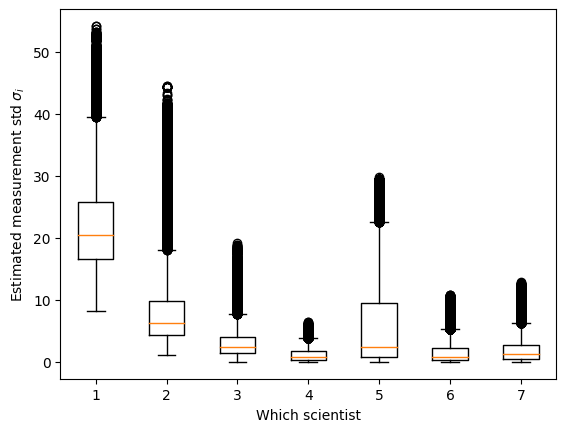

In [29]:
plt.boxplot(new_sigma_chain[N_burnin:].T, positions=np.arange(1, 8));
plt.xlabel("Which scientist")
plt.ylabel("Estimated measurement std $\sigma_i$");

In [30]:
# (GRADING)

In [31]:
# (GRADING)